# Regresión Logística

__Por:__ _Ayar Yuman Paco Sanizo_

__Club de Ciencia de Datos - La Paz__

In [109]:
# Importar librerias

# Librerias para la implementación
import numpy as np
import numpy.linalg as LA
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Librerias para verificar resultados
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression

## 1. Implementación de Algoritmos de Estimación

### 1.1 Funciones Auxiliares

In [2]:
# Función para calcular el estimador de p
def calc_p(X, beta):
    m = X.dot(beta)
    p = np.exp(m)/(1+np.exp(m))
    return(p)

In [27]:
# Función de log-verosimilitud (-Costo)
def log_ver(y, m, p):
    lv = y.T.dot(np.log(p/(1-p)))+(m-y).T.dot(np.log(p))
    return(lv)

### 1.2 Gradient Descent

In [80]:
# Gradient descent
def grad_descent(y, X, beta, m=1, alpha=0.01,epocs=1000,eps=1e-7):
    
    # Estimar p
    p = calc_p(X,beta)
    
    # Calcular gradiente
    gradiente = -X.T.dot(y - m*p)
    
    # Definir historial de costos y betas
    costos = []
    costo = float(-log_ver(y,m,p))
    costos.append(costo)
    
    beta_hist = pd.DataFrame(beta.T)
    
    # Contador
    i=0
    
    while(LA.norm(gradiente)>eps and i<epocs):
        
        # Actualizar beta
        beta = beta - alpha*gradiente
        
        # Estimar p
        p = calc_p(X,beta)
        
        # Calcular gradiente
        gradiente = -X.T.dot(y - m*p)
        
        # Actualizar historial
        costo = float(-log_ver(y,m,p))
        costos.append(costo)
        
        beta_hist=beta_hist.append(pd.DataFrame(beta.T),ignore_index=True) 
        
        # Incrementar contador
        i=i+1
    
    # Mostrar historial de betas
    print(beta_hist)
    
    # Graficar evolución del costo
    plt.plot(costos)
    
    return(beta, costo)

### 1.3 Fisher Scoring

In [214]:
# Fisher Scoring
def fisher_scoring(X, y, beta, m=1, eps1=1e-7, maxit=100):
    
    # Calcular probabilidades
    p = calc_p(X, beta)
    
    # Calcular función Score
    score = X.T.dot(y - m*p)
    
    # Calcular Información de Fisher
    var = (m*p * (1 - p)).T
    var = np.diag(var[0])
    IF =  X.T.dot(var).dot(X)
    
    # Definir historial de betas
    beta_hist = pd.DataFrame(beta.T)
    
    # Definir historial de costos
    costos= []
    costo = float(-log_ver(y,m,p))
    costos.append(costo)
    
    # Contador
    i=0
    
    # Bucle de optimización
    while(LA.norm(score)>eps1 and i<maxit):
        
        # Actualizar beta
        beta = beta + LA.inv(IF).dot(score)
        
        # Calcular probabilidades
        p = calc_p(X, beta)
        
        # Calcular función Score
        score = X.T.dot(y - m*p)
        
        # Calcular Información de Fisher
        var = (m*p * (1 - p)).T
        var = np.diag(var[0])
        IF =  X.T.dot(var).dot(X)
        
        # Actualizar historial
        beta_hist=beta_hist.append(pd.DataFrame(beta.T),ignore_index=True) 
        
        costo = float(-log_ver(y,m,p))
        costos.append(costo)
        
        # Incrementar contador
        i=i+1
    
    # Mostrar historial de betas
    print(beta_hist)    
    
    # Graficar evolución del costo
    plt.plot(costos)
    
    # Retornar el beta óptimo y el costo alcanzado
    return(beta, costo)

## 2. Ejemplos numéricos

Una vez definidos los algoritmos procedemos a verificiar si podemos obtener estimadores adecuadamente. A continuación se consideran datos donde las varaibles de respuesta que siguen distribuciones Bernoulli y distribuciones Binomiales.

### 2.1 Datos con respuestas Bernoulli

En el siguiente conjunto de datos de pacientes tenemos:

__Variable de respuesta__

* $Ataque2_i$: Indicatriz de que el paciente $i$ haya sufrido un segundo ataque al corazón. 

__Variables predictoras__

* $TEnojo_i$: Indicatriz de que se haya aplicado un tratamiento de enojo al paciente $i$.
* $TAnsiedad_i$: Puntaje del paciente $i$ en un test de ansiedad.

In [222]:
# Lectura de datos
data = pd.DataFrame(np.matrix([[1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0],
                               [1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0],
                               [70,80,50,60,40,65,75,80,70,60,65,50,45,35,40,50,55,45,50,60]]).T,
                    columns=['Ataque2','TEnojo','TAnsiedad'])
data

,Ataque2,TEnojo,TAnsiedad
0,1,1,70
1,1,1,80
2,1,1,50
3,1,0,60
4,1,0,40
5,1,0,65
6,1,0,75
7,1,0,80
8,1,0,70
9,1,0,60


#### 2.1.1 Estimación de parámetros

In [223]:
# Preparación de variables
y =np.array(data['Ataque2'])
y.shape = (len(y),1)

x1 = np.array(data['TEnojo'])
x2 = np.array(data['TAnsiedad'])

X = np.stack((np.ones(len(y)),x1,x2)).T

In [224]:
# Definición de un beta inicial
beta_0 = np.array([math.log(sum(y) / sum(1 - y)), 0, 0])
beta_0.shape=(3,1)
beta_0

array([[0.],
       [0.],
       [0.]])

__Gradient Descent__

             0         1         2
0     0.000000  0.000000  0.000000
1     0.000000 -0.000015  0.000775
2    -0.000002 -0.000031  0.001416
3    -0.000006 -0.000048  0.001947
4    -0.000012 -0.000065  0.002387
5    -0.000019 -0.000083  0.002751
6    -0.000027 -0.000101  0.003053
7    -0.000035 -0.000120  0.003304
8    -0.000045 -0.000139  0.003511
9    -0.000055 -0.000158  0.003684
10   -0.000065 -0.000178  0.003827
11   -0.000076 -0.000197  0.003946
12   -0.000087 -0.000217  0.004044
13   -0.000099 -0.000237  0.004126
14   -0.000111 -0.000257  0.004195
15   -0.000122 -0.000277  0.004251
16   -0.000135 -0.000297  0.004298
17   -0.000147 -0.000317  0.004338
18   -0.000159 -0.000337  0.004370
19   -0.000171 -0.000358  0.004397
20   -0.000184 -0.000378  0.004420
21   -0.000197 -0.000398  0.004439
22   -0.000209 -0.000419  0.004455
23   -0.000222 -0.000439  0.004468
24   -0.000235 -0.000459  0.004479
25   -0.000247 -0.000480  0.004488
26   -0.000260 -0.000500  0.004496
27   -0.000273 -0.00

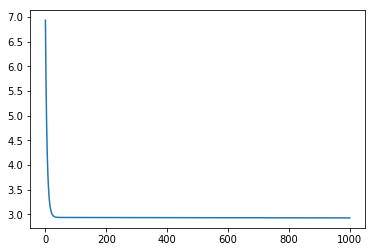

In [225]:
# Estimación por gradient descent
beta_gd, costo_gd = grad_descent(y, X, beta_0, alpha=0.00001,epocs=1000)

In [250]:
# Costo
print(costo_gd)

2.9264588492334243


In [251]:
# Matriz de confusión
cm_gd = confusion_matrix(y, np.round(calc_p(X, beta_gd),0))
print(cm_gd)

[[ 0 10]
 [ 0 10]]


In [252]:
# Medida de error
(cm_gd[0,0]+cm_gd[1,1])/y.size

0.5

__Fisher Scoring__

          0         1         2
0  0.000000  0.000000  0.000000
1 -4.518010 -0.696398  0.084391
2 -6.021025 -0.959954  0.112636
3 -6.349819 -1.021373  0.118791
4 -6.363447 -1.024101  0.119044
5 -6.363470 -1.024106  0.119045


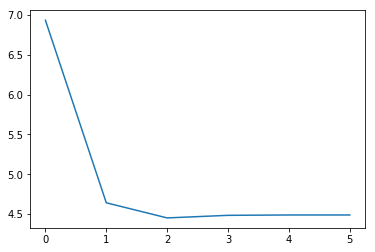

In [227]:
# Estimación por fisher scoring
beta_fs, costo_fs = fisher_scoring(X, y, beta_0)

In [247]:
# Costo
print(costo_fs)

4.4891618404674976


In [248]:
# Matriz de confusión
cm_fs = confusion_matrix(y, np.round(calc_p(X, beta_fs),0))
print(cm_fs)

[[7 3]
 [2 8]]


In [249]:
# Medida de Error
(cm_fs[0,0]+cm_fs[1,1])/y.size

0.75

#### 2.1.2 Verificación de resultados

A continuación verificamos si obtenemos estimadores próximos a los que se obtenienen usando dos librerías.

__StatsModels__

In [229]:
sm_model = smf.glm(formula = 'Ataque2 ~ TEnojo + TAnsiedad', data=data, family=sm.families.Binomial())
result = sm_model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                Ataque2   No. Observations:                   20
Model:                            GLM   Df Residuals:                       17
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -9.4102
Date:                Fri, 22 Jun 2018   Deviance:                       18.820
Time:                        22:25:23   Pearson chi2:                     17.6
No. Iterations:                     5                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.3635      3.214     -1.980      0.048     -12.663      -0.064
TEnojo        -1.0241      1.171     -0.874      0.3

__Sklearn__

In [230]:
sk_model = LogisticRegression()
sk_model.fit(X[:,1:],y.ravel())
beta_sk=np.zeros([3, 1])
beta_sk[0,0]=sk_model.intercept_
beta_sk[1,0]=sk_model.coef_[0][0]
beta_sk[2,0]=sk_model.coef_[0][1]
beta_sk

array([[-0.89939683],
       [-0.78848242],
       [ 0.02525792]])

In [244]:
# Costo
print(-log_ver(y, m=1, p=calc_p(X, beta_sk)))

[[2.80179402]]


In [245]:
# Matriz de confución
cm_sk = confusion_matrix(y, np.round(calc_p(X, beta_sk),0))
print(cm_sk)

[[6 4]
 [1 9]]


In [246]:
# Medida de Error
(cm_sk[0,0]+cm_sk[1,1])/y.size

0.75

### 2.1 Datos con respuestas Binomiales

En este caso el conjunto de datos corresponde a escarabajos.

__Variable de Respuesta__ 

* $y_i$: Número de escarabajos muertos respecto a un total de $n_i$ expuestos a cierta concentración $i$ de veneno

__Variables Predictoras__ 

* $conc_i$: Concentración $i$ de un veneno
* ${conc_i}^2$: Concentración $i$ del veneno al cuadrado

In [255]:
# Lectura de datos
data=pd.read_csv("SC1_11_beetles.txt",sep=";")
data

,conc,y,n
0,49.06,2,29
1,52.99,7,30
2,56.91,9,28
3,60.84,14,27
4,64.76,23,30
5,68.69,29,31
6,72.61,29,30
7,76.54,29,29
8,49.06,4,30
9,52.99,6,30


#### 2.2.1 Estimación de parámetros

In [256]:
# Preparación de variables
y=np.array(data.y)
y.shape=(len(y),1)

m=np.array(data.n)
m.shape=(len(m),1)

X=data.conc
X=np.stack((np.ones(len(y)),X,X*X)).T

In [257]:
# Definición de un beta inicial
beta_0 = np.array([math.log(sum(y) / sum(m - y)), 0.0, 0.0])
beta_0.shape=(3,1)
beta_0

array([[0.4262992],
       [0.       ],
       [0.       ]])

__Gradient Descent__

             0             1         2
0     0.426299  0.000000e+00  0.000000
1     0.426299  1.448237e-07  0.000018
2     0.426299  2.353652e-07  0.000033
3     0.426299  2.832492e-07  0.000044
4     0.426299  2.973980e-07  0.000054
5     0.426299  2.847043e-07  0.000061
6     0.426299  2.505335e-07  0.000067
7     0.426299  1.990954e-07  0.000072
8     0.426299  1.337163e-07  0.000076
9     0.426299  5.704209e-08  0.000080
10    0.426299 -2.881079e-08  0.000083
11    0.426299 -1.221410e-07  0.000085
12    0.426299 -2.215752e-07  0.000087
13    0.426299 -3.260007e-07  0.000088
14    0.426299 -4.345138e-07  0.000089
15    0.426299 -5.463781e-07  0.000091
16    0.426299 -6.609925e-07  0.000091
17    0.426299 -7.778659e-07  0.000092
18    0.426299 -8.965957e-07  0.000093
19    0.426299 -1.016852e-06  0.000093
20    0.426299 -1.138365e-06  0.000093
21    0.426299 -1.260911e-06  0.000094
22    0.426299 -1.384308e-06  0.000094
23    0.426299 -1.508406e-06  0.000094
24    0.426299 -1.633081e

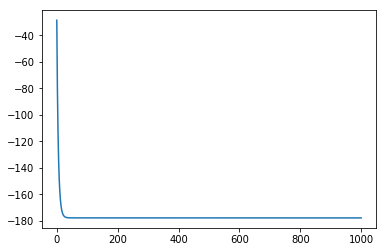

In [258]:
# Estimación por gradient descent
beta_gd2, costo_gd2 = grad_descent(y, X, beta_0, m=m, alpha=0.0000000001,epocs=1000)

In [259]:
print(costo_gd2)

-177.67705922683518


[]

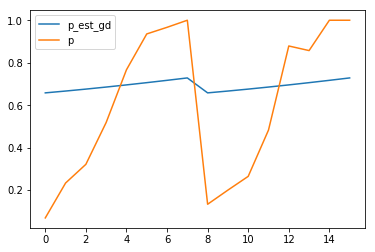

In [260]:
# Gráficos
p_est_gd = calc_p(X, beta_gd2)
plt.plot(p_est_gd, label="p_est_gd")
plt.plot(y/m, label="p")
plt.legend()
plt.plot()

In [261]:
# Medida de Error
sum((y/m-p_est_gd)**2)

array([1.79483308])

__Fisher Scoring__

           0         1         2
0   0.426299  0.000000  0.000000
1 -17.648684  0.424804 -0.002140
2 -11.793852  0.178721  0.000312
3   0.204747 -0.243160  0.003985
4   6.735187 -0.472860  0.005988
5   7.933284 -0.515344  0.006361
6   7.968380 -0.516592  0.006372
7   7.968410 -0.516593  0.006372


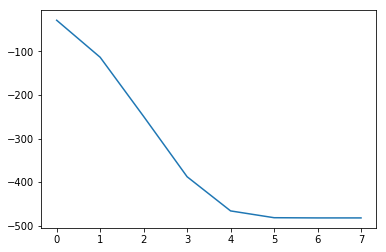

In [262]:
# Estimación
beta_fs2, costo_fs2 = fisher_scoring(X, y, beta_0, m=m)

In [263]:
# Costo
print(costo_fs2)

-482.27855522703067


[]

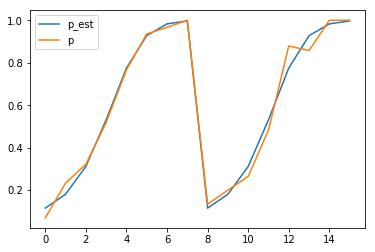

In [264]:
# Graficos
p_est = calc_p(X, beta_fs2)
plt.plot(p_est,label="p_est")
plt.plot(y/m,label="p")
plt.legend()
plt.plot()

In [265]:
# Medida de Error
print(sum((y/m-p_est)**2))

[0.02685729]


#### 2.2.2 Verificación de resultados

A continuación verificamos si obtenemos estimadores próximos a los que se obtenienen usando una librería.

__StatsModels__

In [68]:
model = sm.GLM(np.stack((data.y,data.n-data.y)).T, X, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           ['y1', 'y2']   No. Observations:                   16
Model:                            GLM   Df Residuals:                       13
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -24.948
Date:                Tue, 05 Jun 2018   Deviance:                       7.9273
Time:                        07:30:49   Pearson chi2:                    0.243
No. Iterations:                     7                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.9684     11.036      0.722      0.470     -13.662      29.599
x1            -0.5166      0.374     -1.383      0.1